In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from biodatatools.utils.common import json_load
from biodata.delimited import DelimitedWriter
import sys
import itertools
import glob
import pybedtools
import os
import numpy as np
from collections import defaultdict
import matplotlib.colors as mcolors
import seaborn as sns
import pickle
from pathlib import Path

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [3]:
sys.path.append(str(Path.cwd().parent))
import utils

In [5]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/procapnet/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/"

In [6]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from data_loading import extract_sequences

# Run Fi-NeMo

## Preprocessing

In [7]:
# Keep these models, though we also lower the cutoffs to include EN55
# We may not necessarily explain why we include these models

groups = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")
folders = glob.glob(f"{PROJECT_DIR_o}deepshap_out/*")
samples = [folder.split("/")[-1] for folder in folders if folder.split("/")[-1] in groups["normal_tissues"]]
len(samples)

15

In [8]:
model_type = "strand_merged_umap"
tasks = ["counts", "profile"]

In [202]:
# Get one hot sequences

genome_path = f"{PROJECT_DIR_s}genomes/hg38/hg38.withrDNA.fasta"
chrom_sizes = f"{PROJECT_DIR_s}genomes/hg38/hg38.withrDNA.chrom.sizes"
for s in samples:
	peak_path = f"{PROJECT_DIR_o}processed/{s}/peaks.bed.gz"
	one_hot = extract_sequences(genome_path, chrom_sizes, peak_path, in_window=1000)
	outputfile = f"{PROJECT_DIR_o}finemo/{s}/PROcap_onehot.npz"
	np.savez_compressed(outputfile, one_hot)

Loading genome sequence from /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/genomes/hg38/hg38.withrDNA.fasta
== In Extract Sequences ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN5/peaks.bed.gz
Sequence length: 1000
Num. Examples: 73606
Loading genome sequence from /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/genomes/hg38/hg38.withrDNA.fasta
== In Extract Sequences ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/BCT5/peaks.bed.gz
Sequence length: 1000
Num. Examples: 45550
Loading genome sequence from /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/genomes/hg38/hg38.withrDNA.fasta
== In Extract Sequences ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks.bed.gz
Sequence length: 1000
Num. Examples: 63427
Loading genome sequence from /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/genomes/hg38/hg38.withrDNA.fasta
== In Extract

In [10]:
for s in samples:
	one_hot = f"{PROJECT_DIR_o}finemo/{s}/PROcap_onehot.npz"
	for task in tasks:
		contrib = f"{PROJECT_DIR_o}deepshap_out/{s}/{model_type}/merged/all_{task}_deepshap.npy"
		output_prefix = f"{PROJECT_DIR_o}finemo/{s}/PROcap_{task}"
		utils.finemo_preprocessing(one_hot, contrib, output_prefix)

finemo extract-regions-modisco-fmt -s /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/PROcap_onehot.npz -a /home/yc2553/projects/HEA/output/procapnet/deepshap_out/EN5/strand_merged_umap/merged/all_counts_deepshap.npy -o /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/PROcap_counts -w 1000
finemo extract-regions-modisco-fmt -s /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/PROcap_onehot.npz -a /home/yc2553/projects/HEA/output/procapnet/deepshap_out/EN5/strand_merged_umap/merged/all_profile_deepshap.npy -o /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/PROcap_profile -w 1000
finemo extract-regions-modisco-fmt -s /home/yc2553/projects/HEA/output/procapnet/finemo/BCT5/PROcap_onehot.npz -a /home/yc2553/projects/HEA/output/procapnet/deepshap_out/BCT5/strand_merged_umap/merged/all_counts_deepshap.npy -o /home/yc2553/projects/HEA/output/procapnet/finemo/BCT5/PROcap_counts -w 1000
finemo extract-regions-modisco-fmt -s /home/yc2553/projects/HEA/output/procapnet/finemo/B

## Call hits

In [11]:
# ENCODE narrowPeak format for FiNeMo input requirement

for s in samples:
	peak_path = f"{PROJECT_DIR_o}processed/{s}/peaks.bed.gz"
	b1 = pybedtools.BedTool(peak_path)
	outdir = f"{PROJECT_DIR_o}finemo/{s}/"
	if not os.path.exists(outdir):
		os.mkdir(outdir)
	with DelimitedWriter(f"{outdir}input.bed") as dw:
		for i in b1:
			chrom, start, end = i.fields[:3]
			center = (int(end)-int(start))//2
			dw.write([chrom, start, end, "_".join([chrom, start, end])] + ["."]*5 + [center])

In [12]:
for s in samples:
	peaks = f"{PROJECT_DIR_o}finemo/{s}/input.bed"
	for task in tasks:
		regions = f"{PROJECT_DIR_o}finemo/{s}/PROcap_{task}.npz"
		modisco = f"{PROJECT_DIR_o}modisco_out/{s}/{model_type}/merged/{task}_modisco_results.hd5"
		outdir = f"{PROJECT_DIR_o}finemo/{s}/{task}/"
		utils.finemo_call_hits(regions, modisco, outdir, peaks)

finemo call-hits -r /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/PROcap_counts.npz -m /home/yc2553/projects/HEA/output/procapnet/modisco_out/EN5/strand_merged_umap/merged/counts_modisco_results.hd5 -o /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/counts/ -p /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/input.bed -a 0.7 -J
finemo call-hits -r /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/PROcap_profile.npz -m /home/yc2553/projects/HEA/output/procapnet/modisco_out/EN5/strand_merged_umap/merged/profile_modisco_results.hd5 -o /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/profile/ -p /home/yc2553/projects/HEA/output/procapnet/finemo/EN5/input.bed -a 0.7 -J
finemo call-hits -r /home/yc2553/projects/HEA/output/procapnet/finemo/BCT5/PROcap_counts.npz -m /home/yc2553/projects/HEA/output/procapnet/modisco_out/BCT5/strand_merged_umap/merged/counts_modisco_results.hd5 -o /home/yc2553/projects/HEA/output/procapnet/finemo/BCT5/counts/ -p /home/yc2553/projects

# Heatmap

In [9]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [10]:
inputfile = f"{PROJECT_DIR_o}modisco_out/all_motifs.json"
with open(inputfile, "rb") as f:
    motifs = pickle.load(f)

In [11]:
motif_names = set()
for s, task in itertools.product(samples, tasks):
	motif_names |= set(motifs[(s,task)])
len(motif_names), motif_names

(29,
 {'AP1',
  'ATF4',
  'CEBPA',
  'CEBPB',
  'CREB',
  'CTCF',
  'ELK1-SREBF2',
  'ETS',
  'HNF1',
  'HNF4',
  'HSF',
  'IRF',
  'Inr-CA',
  'Inr-TA',
  'MEF2',
  'NFY',
  'NR3C2',
  'NRF1',
  'RFX',
  'SP',
  'SRF',
  'TATA',
  'THAP11',
  'THAP11-ZNF143',
  'USF1',
  'YY1',
  'ZBTB33',
  'ZNF143',
  'ZNF384'})

In [12]:
def motif_mapping(row, motifs):
    idx = int(row["motif_name"].split("_")[-1])
    return next((k for k, v in motifs.items() if v == idx), np.nan)

In [13]:
df_motifs = {}
for s, task in itertools.product(samples, tasks):
	df = pd.read_table(f"{PROJECT_DIR_o}finemo/{s}/{task}/hits.tsv")
	df["motif"] = df.apply(lambda row: motif_mapping(row, motifs[(s, task)]), axis=1)
	df = df.dropna()
	motif_col = df.pop("motif")
	df.insert(3, "motif", motif_col)
	df_motifs[(s, task)] = df
	outputfile = f"{PROJECT_DIR_o}finemo/{s}/{task}/hits_with_motif_names.bed"
	df.columns = ["#chr"] + list(df.columns[1:])
	df.to_csv(outputfile, sep="\t", index=False)

In [18]:
n_hits = defaultdict(dict)
for s, task in itertools.product(samples, tasks):
	for motif in motif_names:
		df = df_motifs[(s, task)][df_motifs[(s, task)]["motif"]==motif]
		n_hits[(s, task)][motif] = len(set(df["peak_name"])) if motif in motifs[(s, task)] else np.nan

In [15]:
samples_order = ["BCT5", "EN6", "CHTN15", "GT22",
				 "EN55", "GT24", "EN5", "EN3", "EN4",
				 "EN18", "EN23", 
				 "GT1", "GT17",
				 "EN12", "GT23",
				]

In [16]:
# Order the motifs 
# Inr first
# More ubiquitous motifs
# More tissue-specific motifs; diagonal line

motif_names_ordered = ["Inr-CA", "Inr-TA", "TATA",
					   "SP", "ETS", "CREB", "NFY", "NRF1",
					   "AP1", "ZBTB33", "ZNF384",
					   "THAP11-ZNF143", "THAP11", "ZNF143",
					  ]
for s, task in itertools.product(samples_order, tasks):
	for motif in motifs[(s, task)]:
		if motif not in motif_names_ordered:
			motif_names_ordered.append(motif)
len(motif_names_ordered)

29

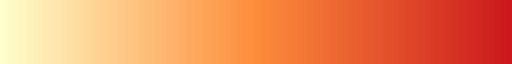

In [17]:
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#ffffcc", "#fd8d3c", "#cb181d"])
cmap.set_bad(color="#d9d9d9")
cmap

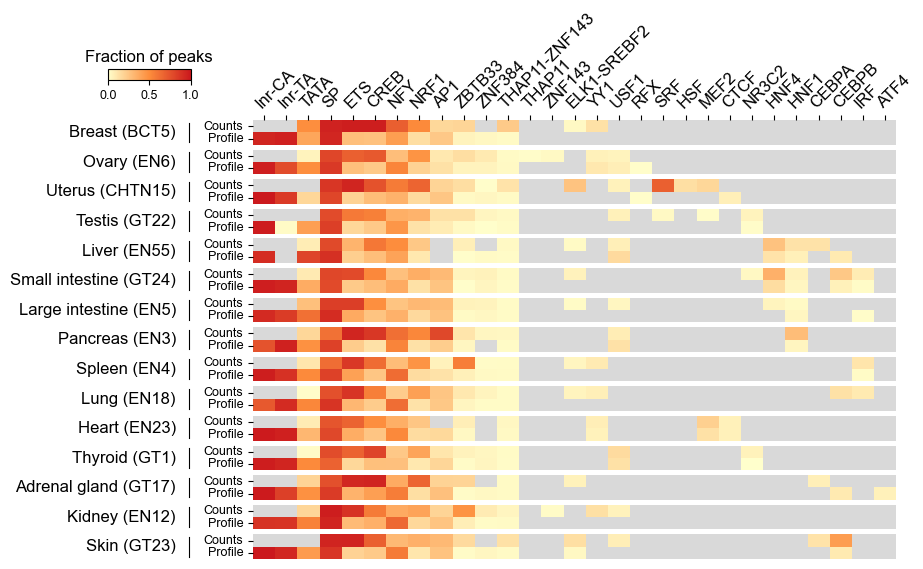

In [32]:
fig, ax = plt.subplots(len(samples), 1, figsize=(8.3, 5.7))
for s in samples_order:
	row = samples_order.index(s)
	n_peaks = len(pybedtools.BedTool(f"{PROJECT_DIR_o}finemo/{s}/input.bed"))
	results = []
	for motif in motif_names_ordered:
		results.append([n_hits[(s, task)][motif]/n_peaks if (s, task) in n_hits else np.nan for task in tasks])
	df_num = pd.DataFrame(results, index=motif_names_ordered, columns=[task.capitalize() for task in tasks])
	xticklabels=True if row == 0 else False
	g = sns.heatmap(df_num.T, xticklabels=xticklabels, yticklabels=True, 
					vmin=0, vmax=1, cmap=cmap, cbar=None, ax=ax[row])
	if xticklabels:
	    ax[row].tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
	g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor', fontsize=bfontsize)
	
	g.set_ylabel(f"{labels[s][1]} ({s})", fontsize=bfontsize, rotation=0, 
				 ha="right", va="center", labelpad=20)
	g.tick_params(axis="y", labelsize=sfontsize, rotation=0)
	g.plot([-0.1, -0.1], [0.1, 0.9], transform=g.transAxes, color='black', clip_on=False, lw=lw)
	
cbar_ax = fig.add_axes([-0.05, 0.95, 0.1, 0.02])
cbar = plt.colorbar(g.collections[0], cax=cbar_ax, orientation="horizontal")
cbar.set_label("Fraction of peaks", fontsize=bfontsize, labelpad=5)  
cbar.ax.xaxis.set_label_position('top')
cbar.set_ticks([0, 0.5, 1])
cbar.ax.tick_params(labelsize=sfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/Fig4a.pdf", bbox_inches="tight", transparent=True)